In [1]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [2]:
import csv
import time

import sys
sys.path.insert(0, "../../utils/")
import utils as ut
import fancyplots as fp
from regr_models import neuralNewtorkRegression

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

## Input options

In [3]:
# training options
write_output     = False
remove_some_mass = False
epochs           = 50
validation_split = 0.2
batch_size       = 64
verbose_training = False
hlayers_sizes    = [100];
learning_rate    = 0.001
scaler_type      = 'minmax' # standard, minmax, mixed
hidden_activation= 'relu'
out_activation   = 'linear' # sigmoid, linear, linear_cut, linear_cut_T3, linear_cut_lb, linear_cut_mod
loss_function    = 'mse'
Lambda_mse       = 1        # used if loss_function has a q-penalty (e.g. 'mse_q')
Lambda_q         = 100        
Lambda_Mc        = 3

show_SVR = True
show_2m  = True

## Train and test the model on the dataset with only the two mass

In [4]:
# load data
features_names       = ['m1', 'm2', 'Mc']
regr_data_dir        = '../../datasets/GSTLAL_EarlyWarning_Dataset/Dataset/m1m2Mc/'
data_paths           = {}
data_paths['xtrain'] = regr_data_dir+'xtrain.csv'
data_paths['ytrain'] = regr_data_dir+'ytrain.csv'
data_paths['xtest']  = regr_data_dir+'xtest.csv'
data_paths['ytest']  = regr_data_dir+'ytest.csv'


rdl_out = ut.regressionDatasetLoader(data_paths, features_names,
                       remove_some_mass=remove_some_mass,
                       scaler_type=None)
xtrain_notnormalized = rdl_out['xtrain']
ytrain_notnormalized = rdl_out['ytrain']
xtest_notnormalized  = rdl_out['xtest']
ytest_notnormalized  = rdl_out['ytest']
labels               = rdl_out['labels']

********************************************************************************
Layers: 100 
trainable pramaters: 703
train time: 12.912
********************************************************************************

Final loss     : 0.01053
Final R2 mean  : 0.83923
R2[ 0]         : 0.73607
R2[ 1]         : 0.78165
R2[ 2]         : 0.99995


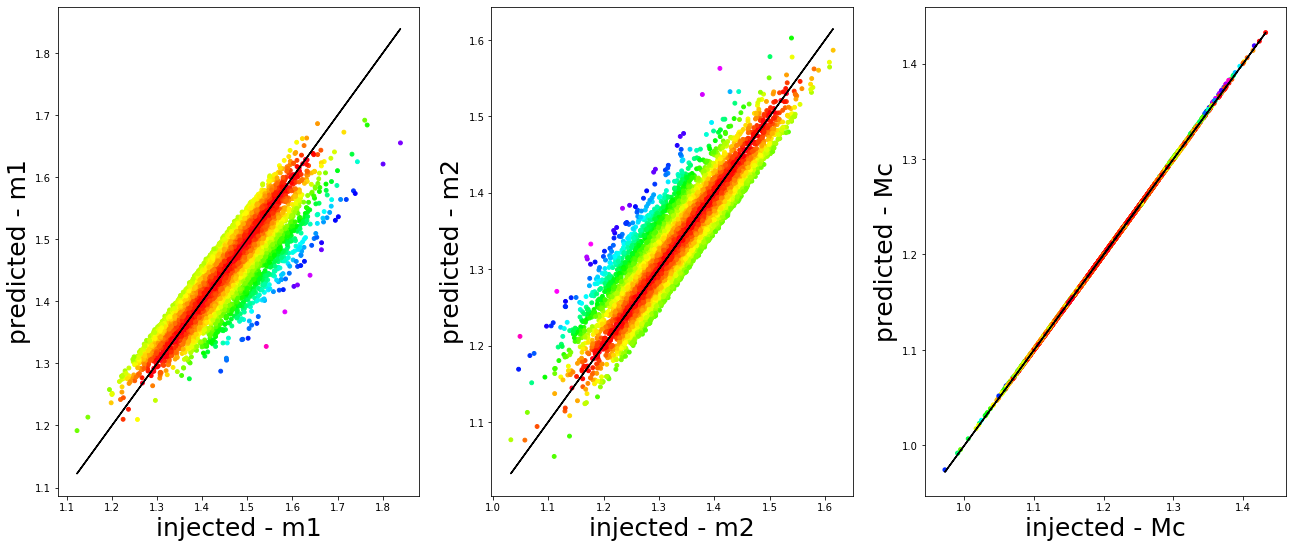

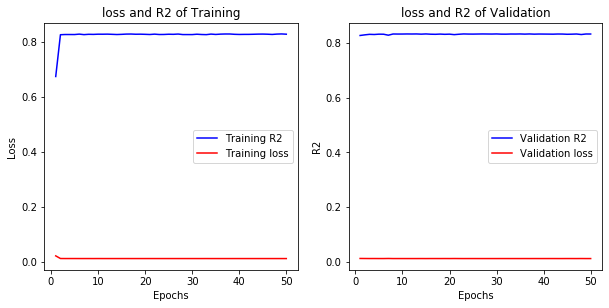

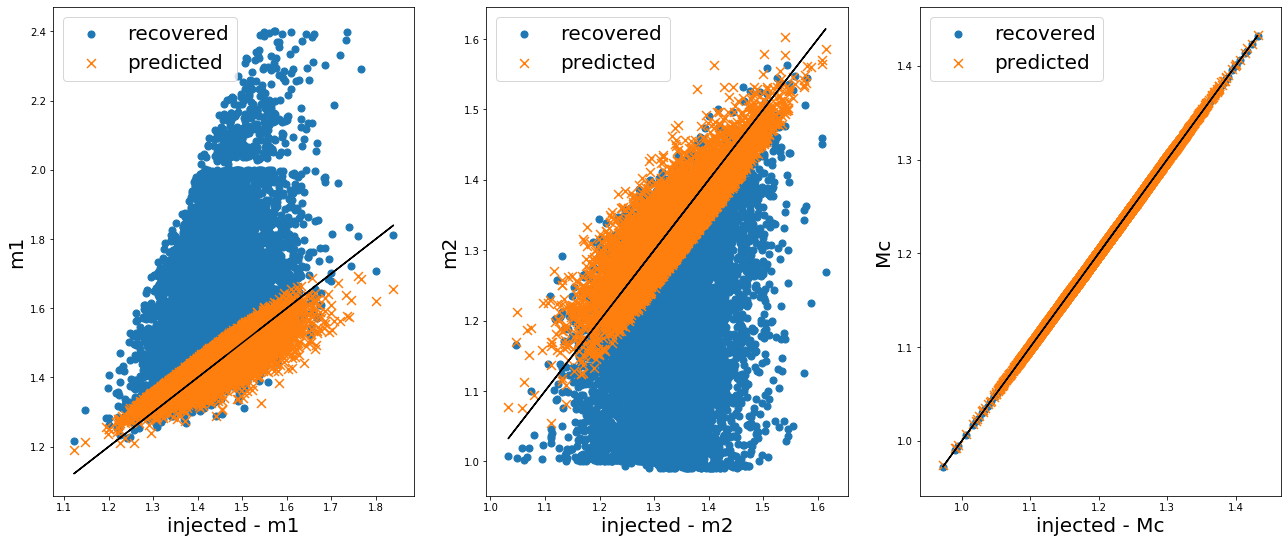

********************************************************************************
m1 vs m2: injected, recovered, predicted
********************************************************************************


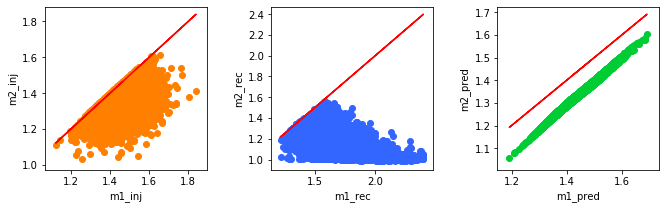

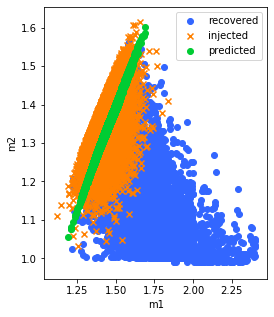

********************************************************************************
m1 vs q: injected, recovered, predicted (indirectly)
********************************************************************************


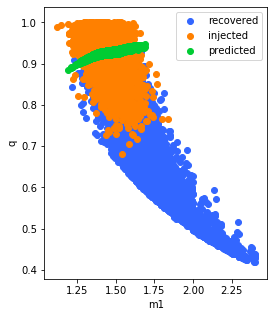

********************************************************************************
m1 vs Mc: injected, recovered, predicted
********************************************************************************


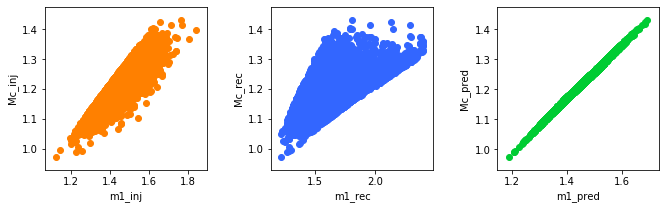

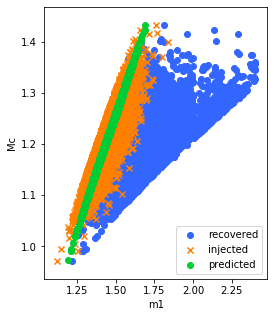

In [5]:
# train model
t0 = time.perf_counter()
outNN = neuralNewtorkRegression(xtrain_notnormalized, ytrain_notnormalized,
            scaler_type       = scaler_type,                   
            epochs            = epochs, 
            batch_size        = batch_size, 
            learning_rate     = learning_rate,          
            validation_split  = validation_split,   
            verbose           = verbose_training,             
            hlayers_sizes     = hlayers_sizes,          
            out_activation    = out_activation,        
            hidden_activation = hidden_activation,
            loss_function     = loss_function,
            Lambda_mse        = Lambda_mse, 
            Lambda_q          = Lambda_q,
            Lambda_Mc         = Lambda_Mc)
train_time = time.perf_counter()-t0

model    = outNN["model"]
history  = outNN["history"]
Npars    = outNN["Npars"]
scaler_x = outNN["scaler_x"]
scaler_y = outNN["scaler_y"]

xtest = scaler_x.transform(xtest_notnormalized)
ytest = scaler_y.transform(ytest_notnormalized)

# predict
ypredicted = model.predict(xtest)

# print some information
metrics_dict = ut.evalutationMetricsDict(xtest,ytest,model)

# show plots and print info
asterisks = '*'*80
print(asterisks)
print('Layers: ', end='')
for layer in hlayers_sizes:
    print(layer,end=' ')
print('\ntrainable pramaters: ', Npars, \
      '\ntrain time: {:.3f}'.format(train_time), '\n', \
      asterisks, sep='', end='\n')
ut.printMetrics(metrics_dict)

# save info/score/model in the dictionary
dict1                     = lambda:0
dict1.Npars               = Npars
dict1.metrics             = metrics_dict
dict1.train_time          = train_time
dict1.Nlayers             = len(hlayers_sizes)
dict1.hlayers_sizes       = hlayers_sizes
dict1.epochs              = epochs
dict1.batch_size          = batch_size
dict1.scaler_type         = scaler_type
dict1.out_activation      = out_activation
dict1.hidden_activation   = hidden_activation
dict1.learning_rate       = learning_rate
dict1.prediction          = ypredicted
dict1.prediction_rescaled = scaler_y.inverse_transform(ypredicted)
dict1.loss_function       = loss_function
dict1.scaler_x            = scaler_x
dict1.scaler_y            = scaler_y
dict1.model               = model
dict1.history             = history

# plots
fp.regrPredictionPlots(ytest, ypredicted, labels, scaler=scaler_y)
fp.plotHistory(history)
fp.checkRegressionPlot(xtest, ytest, ypredicted, labels, \
                   scaler_y=scaler_y, scaler_x=scaler_x)
fp.plotInjRecPred(ytest_notnormalized, xtest_notnormalized, \
                  dict1.prediction_rescaled, idx_Mc=2)


## Try predicting Mc,m2 and computing m1 (spoiler: nothing change)

********************************************************************************
Layers: 100 
trainable pramaters: 502
train time: 14.860
********************************************************************************

Final loss     : 0.00662
Final R2 mean  : 0.88990
R2[ 0]         : 0.78207
R2[ 1]         : 0.99774


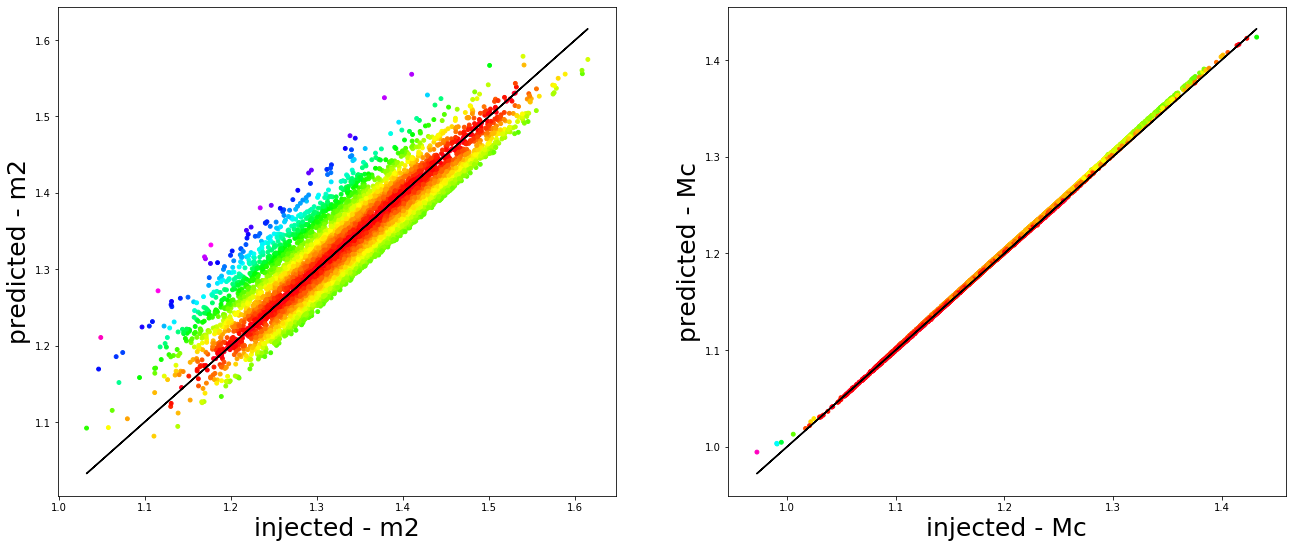

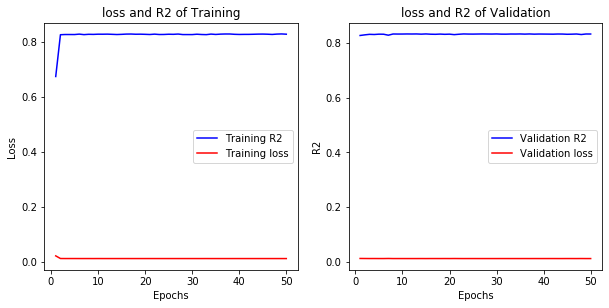

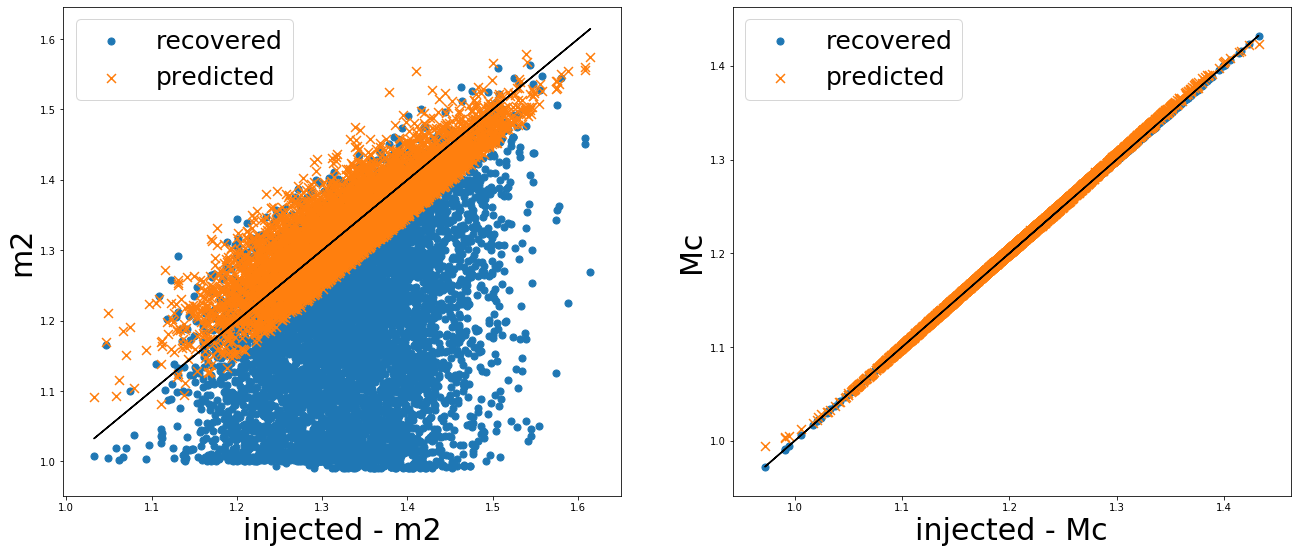

********************************************************************************
m1 vs m2: injected, recovered, predicted
********************************************************************************


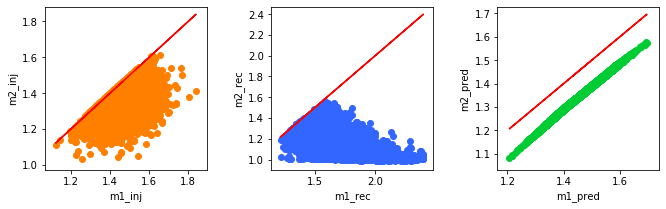

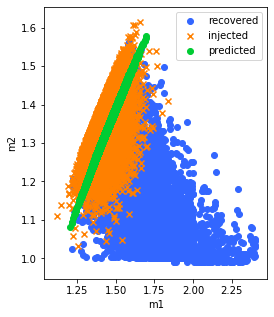

********************************************************************************
m1 vs q: injected, recovered, predicted (indirectly)
********************************************************************************


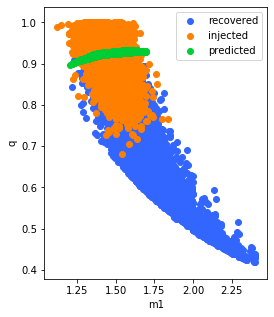

********************************************************************************
m1 vs Mc: injected, recovered, predicted
********************************************************************************


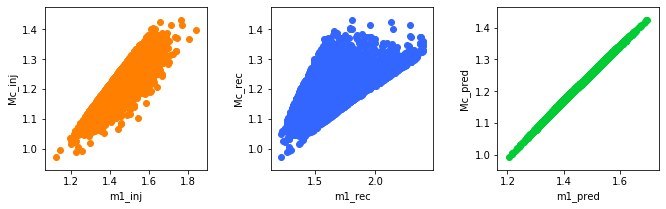

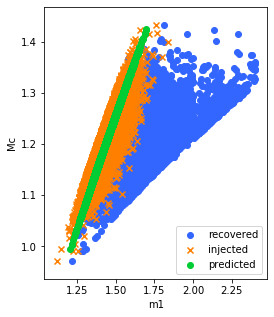

In [6]:
if show_2m:
    xtrain_notnormalized_d2 = rdl_out['xtrain'][:,1:3]
    ytrain_notnormalized_d2 = rdl_out['ytrain'][:,1:3]
    xtest_notnormalized_d2  = rdl_out['xtest'][:,1:3]
    ytest_notnormalized_d2  = rdl_out['ytest'][:,1:3]
    labels_d2               = rdl_out['labels'][1:3]

    # train model
    t0 = time.perf_counter()
    outNN = neuralNewtorkRegression(xtrain_notnormalized_d2, ytrain_notnormalized_d2,
                scaler_type       = scaler_type,                   
                epochs            = epochs, 
                batch_size        = batch_size, 
                learning_rate     = learning_rate,          
                validation_split  = validation_split,   
                verbose           = verbose_training,             
                hlayers_sizes     = hlayers_sizes,          
                out_activation    = out_activation,        
                hidden_activation = hidden_activation,
                loss_function     = loss_function
            )
    train_time = time.perf_counter()-t0

    model_d2    = outNN["model"]
    history_d2  = outNN["history"]
    Npars_d2    = outNN["Npars"]
    scaler_x_d2 = outNN["scaler_x"]
    scaler_y_d2 = outNN["scaler_y"]

    xtest_d2 = scaler_x_d2.transform(xtest_notnormalized_d2)
    ytest_d2 = scaler_y_d2.transform(ytest_notnormalized_d2)

    # predict
    ypredicted_d2 = model_d2.predict(xtest_d2)

    # print some information
    metrics_dict_d2 = ut.evalutationMetricsDict(xtest_d2,ytest_d2,model_d2)

    # show plots and print info
    asterisks = '*'*80
    print(asterisks)
    print('Layers: ', end='')
    for layer in hlayers_sizes:
        print(layer,end=' ')
    print('\ntrainable pramaters: ', Npars_d2, \
          '\ntrain time: {:.3f}'.format(train_time), '\n', \
          asterisks, sep='', end='\n')
    ut.printMetrics(metrics_dict_d2)

    # save info/score/model in the dictionary
    dict2                     = lambda:0
    dict2.Npars               = Npars_d2
    dict2.metrics             = metrics_dict_d2
    dict2.train_time          = train_time
    dict2.Nlayers             = len(hlayers_sizes)
    dict2.hlayers_sizes       = hlayers_sizes
    dict2.epochs              = epochs
    dict2.batch_size          = batch_size
    dict2.scaler_type         = scaler_type
    dict2.out_activation      = out_activation
    dict2.hidden_activation   = hidden_activation
    dict2.learning_rate       = learning_rate
    dict2.prediction          = ypredicted_d2
    dict2.prediction_rescaled = scaler_y_d2.inverse_transform(ypredicted_d2)
    dict2.loss_function       = loss_function
    dict2.scaler_x            = scaler_x
    dict2.scaler_y            = scaler_y
    dict2.model               = model
    dict2.history             = history
    
    # plots
    fp.regrPredictionPlots(ytest_d2, ypredicted_d2, labels_d2, scaler=scaler_y_d2)
    fp.plotHistory(history)
    fp.checkRegressionPlot(xtest_d2, ytest_d2, ypredicted_d2, labels_d2, \
                       scaler_y=scaler_y_d2, scaler_x=scaler_x_d2)

    m2_pred = dict2.prediction_rescaled[:,0]
    Mc_pred = dict2.prediction_rescaled[:,1]
    m1_pred = ut.findSecondMassFromMc(Mc_pred,m2_pred)

    prediction_d2 = np.column_stack((m1_pred, m2_pred, Mc_pred))

    fp.plotInjRecPred(ytest_notnormalized, xtest_notnormalized, prediction_d2, \
                      idx_Mc=2)

## Try regression with SVR

score #0: 0.72434
score #1: 0.77424
score #2: 0.99989


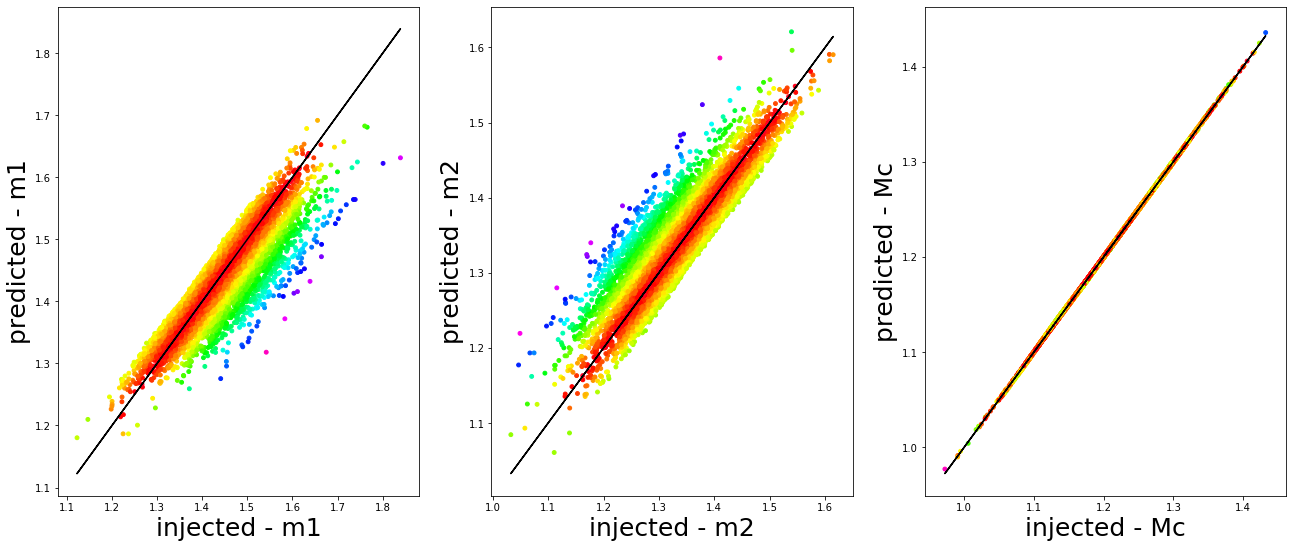

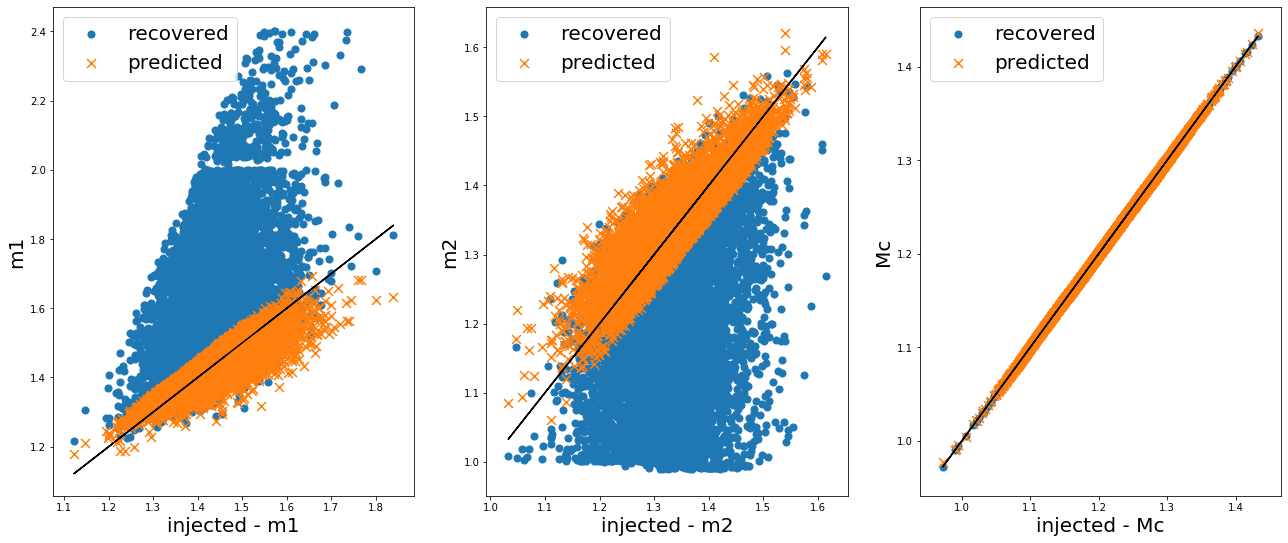

********************************************************************************
m1 vs m2: injected, recovered, predicted
********************************************************************************


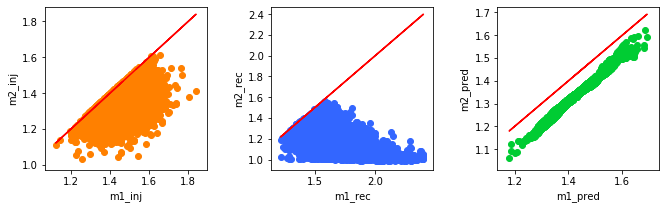

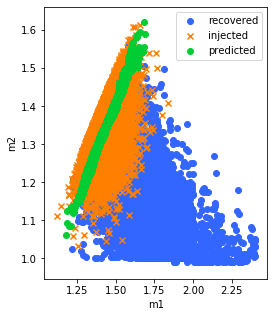

********************************************************************************
m1 vs q: injected, recovered, predicted (indirectly)
********************************************************************************


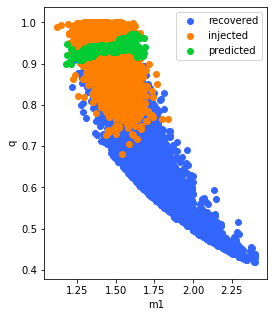

********************************************************************************
m1 vs Mc: injected, recovered, predicted
********************************************************************************


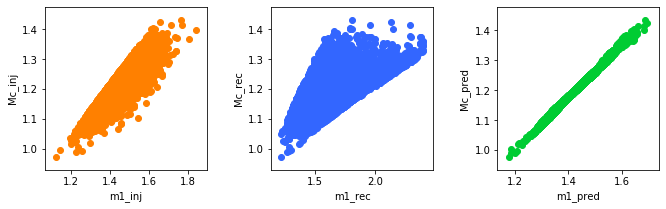

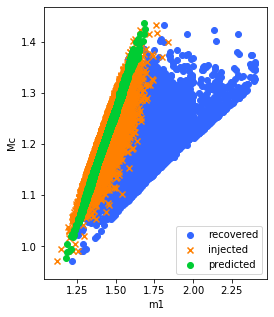

In [7]:
if show_SVR:
    C   = 10
    eps = 0.001;

    Ntest     = len(xtest_notnormalized)
    Nfeatures = len(xtrain_notnormalized[0,:])

    ypredicted_SVR = np.zeros((Ntest, Nfeatures))
    scores = np.zeros(Nfeatures)
    regres = []
    t0 = time.perf_counter()
    for i in range(0,Nfeatures):
            ytrain_SVR_1d = ytrain_notnormalized[:,i]
            regr = make_pipeline(StandardScaler(), SVR(kernel='rbf', C=C, epsilon=eps))
            regr.fit(xtrain_notnormalized, ytrain_SVR_1d)
            ytest_SVR_1d  = ytest_notnormalized[:,i]
            scores[i] = regr.score(xtest_notnormalized, ytest_SVR_1d)
            regres.append(regr)
            print('score #{:1d}: {:.5f}'.format(i, scores[i]))
            ypredicted_SVR[:,i] = regr.predict(xtest_notnormalized)
    train_time = time.perf_counter()-t0

    dict3                     = lambda:0
    dict3.train_time          = train_time
    dict3.prediction_rescaled = ypredicted_SVR
    dict3.scores              = scores

    # plots
    fp.regrPredictionPlots(ytest_notnormalized, ypredicted_SVR, labels)
    fp.checkRegressionPlot(xtest_notnormalized, ytest_notnormalized, \
                           ypredicted_SVR, labels)
    fp.plotInjRecPred(ytest_notnormalized, xtest_notnormalized, \
                      ypredicted_SVR, idx_Mc=2)

## More plots...

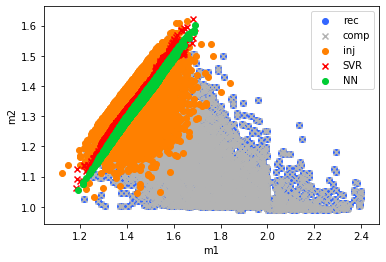

In [8]:
m1_inj = ytest_notnormalized[:,0]
m2_inj = ytest_notnormalized[:,1]
Mc_inj = ut.chirpMass(m1_inj, m2_inj)

m1_rec = xtest_notnormalized[:,0]
m2_rec = xtest_notnormalized[:,1]
if len(xtest_notnormalized[0,:])>2:
    Mc_rec = xtest_notnormalized[:,2]
else:
    Mc_rec = ut.chirpMass(m1_rec, m2_rec)
    
m2_comp = ut.findSecondMassFromMc(Mc_rec, m1_rec)

m1_pred_NN  = dict1.prediction_rescaled[:,0]
m2_pred_NN  = dict1.prediction_rescaled[:,1]

if show_SVR:
    m1_pred_SVR = dict3.prediction_rescaled[:,0]
    m2_pred_SVR = dict3.prediction_rescaled[:,1]

plt.figure
plt.scatter(m1_rec, m2_rec,  marker='o', label='rec', color=[0.2,0.4,1])
plt.scatter(m1_rec, m2_comp, marker='x', label='comp', color=[0.7,0.7,0.7])
plt.scatter(m1_inj, m2_inj,  label='inj', color=[1,0.5,0])
if show_SVR:
    plt.scatter(m1_pred_SVR, m2_pred_SVR, label='SVR', marker='x', color=[1,0,0])
plt.scatter(m1_pred_NN,  m2_pred_NN,  label='NN', color=[0,0.8,0.2])
plt.xlabel('m1')
plt.ylabel('m2')
plt.legend()
plt.show()